In [1]:
import glob
import os
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [2]:
### import some analysis functions we wrote for this project
import sys ; sys.path.append("..")
from ppe_analysis.analysis import *

### grab a dask cluster, if needed
 - needed for any data reductions
 - not needed to just do the plotting steps

In [3]:
# Setup your PBSCluster
import dask
from dask_jobqueue import PBSCluster
from dask.distributed import Client
ncores=1
nmem='25GB'
cluster = PBSCluster(
    cores=ncores, # The number of cores you want
    memory=nmem, # Amount of memory
    processes=1, # How many processes
    queue='casper', # The type of queue to utilize (/glade/u/apps/dav/opt/usr/bin/execcasper)
    local_directory='$TMPDIR', # Use your local directory
    resource_spec='select=1:ncpus='+str(ncores)+':mem='+nmem, # Specify resources
    project='P93300641', # Input your project ID here
    walltime='01:30:00', # Amount of wall time
    interface='ib0', # Interface to use
)

# Scale up
cluster.scale(30)

# Setup your client
client = Client(cluster)

/glade/work/djk2120/miniconda3/envs/ppe-py/lib/python3.7/site-packages/distributed/node.py:161: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 37665 instead
  f"Port {expected} is already in use.\n"


In [4]:
client.cluster

In [5]:
def get_ds(ens,htape,dvs,files=None):
    if not files:
        files= get_files(ens,htape,keys)
    def preprocess(ds):
        return ds[dvs]
    ds = xr.open_mfdataset(files,combine='nested',concat_dim='ens',
                           parallel=True,preprocess=preprocess)
    #make time more sensible
    if htape=='h0' or htape=='h1':
        yr0=ds['time.year'][0].values
        ds['time'] = xr.cftime_range(str(yr0),periods=len(ds.time),freq='MS')
        
    return ds

In [8]:
ds0,la,lapft,attrs,paramkey,keys=ppe_init()

In [10]:
data_vars=['GPP','EFLX_LH_TOT']
htape='h0'
ensemble='CTL2010'
ds=get_ensemble(data_vars,ensemble,htape)

In [37]:
ensemble='C867'
ds2=get_ensemble(data_vars,ensemble,htape)

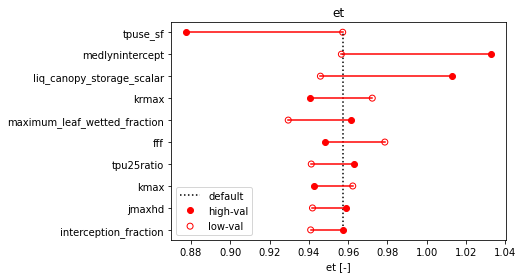

In [39]:
et0=(la*ds.EFLX_LH_TOT).sum(dim='gridcell').mean(dim='time').compute()
et1=(la*ds2.EFLX_LH_TOT).sum(dim='gridcell').mean(dim='time').compute()
et=et1/et0
et.name='et'
et.attrs={'units':'-'}
rank_plot(et,ds,10)

In [44]:
ix = (ds.param=='krmax')&(ds.minmax=='max')
et0.isel(ens=ix)/et0.isel(ens=0)

<xarray.DataArray (ens: 1)>
array([1.03548056])
Coordinates:
  * ens      (ens) int64 144

In [45]:
et1.isel(ens=ix)/et1.isel(ens=0)

<xarray.DataArray (ens: 1)>
array([1.01731468])
Coordinates:
  * ens      (ens) int64 144

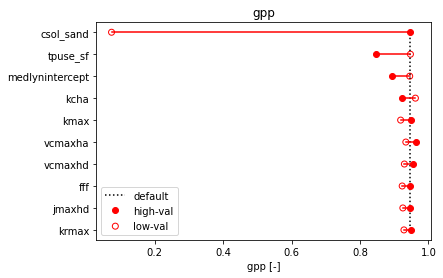

In [36]:
et0=(la*ds.GPP).sum(dim='gridcell').mean(dim='time').compute()
et1=(la*ds2.GPP).sum(dim='gridcell').mean(dim='time').compute()
et=et1/et0
et.name='gpp'
et.attrs={'units':'-'}
rank_plot(et,ds,10)

TypeError: unsupported operand type(s) for +: 'NoneType' and 'str'

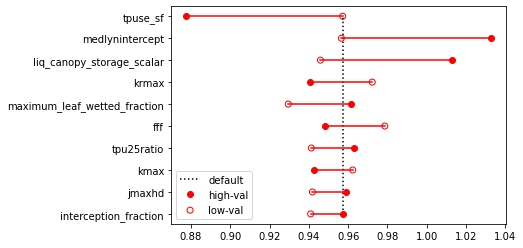

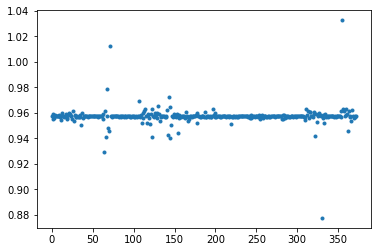

In [21]:
plt.plot(et,'.')

In [29]:
ix = (ds.param=='medlynslope')&(ds.minmax=='max')
et.isel(ens=ix)

<xarray.DataArray (ens: 1)>
array([0.9693643])
Coordinates:
  * ens      (ens) int64 107

In [8]:
files=sorted(glob.glob('/glade/campaign/asp/djk2120/PPEn11/C285/hist/*h1*'))
ds = get_ds('C285','h0',['TLAI'],files=files)

In [9]:
dstmp = xr.open_dataset(files[0])
ds['pft'] = dstmp['pfts1d_itype_veg']

In [10]:
laithresh=0.1
 
npix0     = (ds['TLAI'].isel(ens=0).max(dim='time')>laithresh).groupby('pft').sum().compute()
npixels   = (ds['TLAI'].max(dim='time')>laithresh).groupby('pft').sum().compute()
surv      = 100*npixels/npix0.compute().isel(pft=1+np.arange(15))
thresh    = 70
alive     = surv.T>thresh

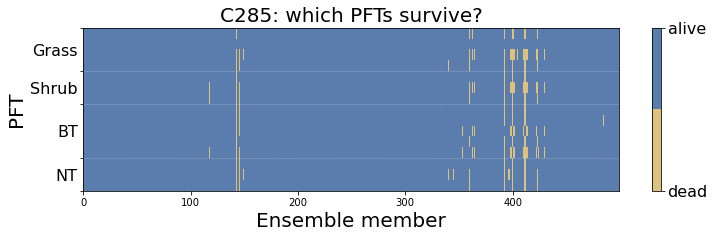

In [19]:
vals = np.ones([2,4])
vals[0,:3]=np.array([223,194,125])/256
vals[1,:3]=np.array([90,125,175])/256
newcmp = matplotlib.colors.ListedColormap(vals)


fig,ax = plt.subplots(figsize=[12,3])
plt.pcolormesh(alive,cmap=newcmp)

cbar=plt.colorbar(ticks=[0, 1])
cbar.ax.set_yticklabels(['dead', 'alive']) 
cbar.ax.tick_params(labelsize=16) 
plt.yticks([0,3,8,11,15])
ax.set_yticks([1.5,5.5,9.5,13], minor=True)
for y in [3,8,11]:
    plt.plot([0,len(ds.ens)],[y,y],':',color=[0.9,0.9,0.9],linewidth=0.5)

ax.yaxis.set_major_formatter(plt.NullFormatter())
ax.set_yticklabels(['NT','BT','Shrub','Grass'],minor=True,fontsize=16)
for tick in ax.yaxis.get_minor_ticks():
    tick.tick1line.set_markersize(0)
    tick.tick2line.set_markersize(0)
plt.title('C285: which PFTs survive?',fontsize=20)
plt.ylabel('PFT',fontsize=20)
plt.xlabel('Ensemble member',fontsize=20);
plt.savefig('./lsms_figs/survival.png',dpi=500,bbox_inches="tight")


In [ ]:
glob.glob('/glade/campaign/asp/djk2120')

In [38]:
ds.TLAI

<xarray.DataArray 'TLAI' (ens: 373, time: 120, pft: 4387)>
dask.array<concatenate, shape=(373, 120, 4387), dtype=float32, chunksize=(1, 120, 4387), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 2005-01-01 00:00:00 ... 2014-12-01 00:00:00
Dimensions without coordinates: ens, pft
Attributes:
    long_name:     total projected leaf area index
    units:         m^2/m^2
    cell_methods:  time: mean

In [8]:
dsets={}
dvs=['GPP','EFLX_LH_TOT','TWS','TLAI','SOILWATER_10CM']
for ens in ['CTL2010','C867','AF2095']:
    dsets[ens]=get_ds(ens,'h0',dvs)

In [12]:
dsets['CTL2010']['TWS']

<xarray.DataArray 'TWS' (ens: 373, time: 120, gridcell: 400)>
dask.array<concatenate, shape=(373, 120, 400), dtype=float32, chunksize=(1, 120, 400), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 2005-01-01 00:00:00 ... 2014-12-01 00:00:00
Dimensions without coordinates: ens, gridcell
Attributes:
    long_name:     total water storage
    units:         mm
    cell_methods:  time: mean

In [17]:
xanns={}
for v in ['GPP','EFLX_LH_TOT','TWS','TLAI','SOILWATER_10CM']:
    print(v)
    
    if v in attrs['cf1']:
        xann      = ann_mean(dsets['CTL2010'][v],cf=attrs['cf1'][v]).mean(dim='year')
    else:
        xann      = ann_mean(dsets['CTL2010'][v]).mean(dim='year')
        
    if v in attrs['cf2']:
        xann_glob = reg_mean(xann ,la ,cf=attrs['cf2'][v])
    else:
        xann_glob = reg_mean(xann ,la)
    xann_glob[ix]=1
    
    if v in attrs['units']:
        units = attrs['units'][v]
    else:
        units = dsets['CTL2010'][v].attrs['units']
    xann_glob.name=v
    xann_glob.attrs={'units':units}
    xanns[v]=xann_glob

GPP
EFLX_LH_TOT
TWS
TLAI
SOILWATER_10CM


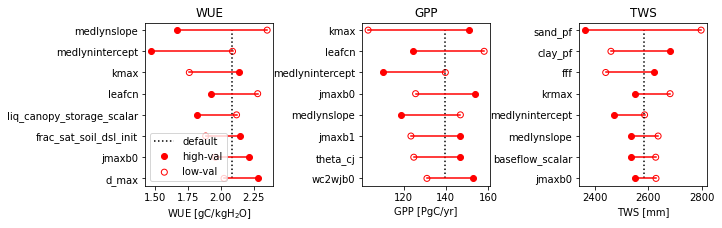

In [59]:
plt.figure(figsize=[13,3])
i=0
for v in ['WUE','GPP','TWS']:
    i+=1
    plt.subplot(1,3,i)
    ll=i==1
    
    if v=='WUE':
        da = xanns['GPP']/xanns['EFLX_LH_TOT']
        da.name = v
        units = r'gC/kgH$_2$O'
    else:
        units = xanns[v].attrs['units']
        da = xanns[v]
    rank_plot(da,ds0,8,xlabel=v+' ['+units+']',ll=ll)
plt.subplots_adjust(left=0.3,wspace=0.7)
plt.savefig('./lsms_figs/rankings.png',dpi=500,bbox_inches="tight")

In [28]:
help(plt.subplots_adjust)

Help on function subplots_adjust in module matplotlib.pyplot:

subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=None)
    Adjust the subplot layout parameters.
    
    Unset parameters are left unmodified; initial values are given by
    :rc:`figure.subplot.[name]`.
    
    Parameters
    ----------
    left : float, optional
        The position of the left edge of the subplots,
        as a fraction of the figure width.
    right : float, optional
        The position of the right edge of the subplots,
        as a fraction of the figure width.
    bottom : float, optional
        The position of the bottom edge of the subplots,
        as a fraction of the figure height.
    top : float, optional
        The position of the top edge of the subplots,
        as a fraction of the figure height.
    wspace : float, optional
        The width of the padding between subplots,
        as a fraction of the average Axes width.
    hspace : float, optional


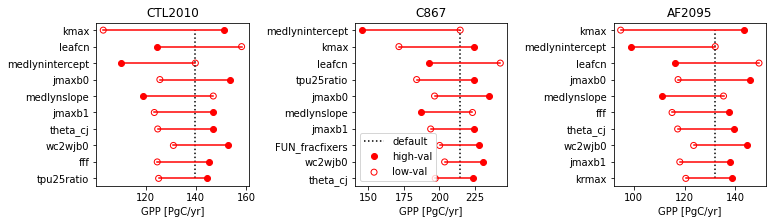

In [61]:
v='GPP'
plt.figure(figsize=[12,3])
for i,ens in enumerate(['CTL2010','C867','AF2095']):

    ds = get_ds(ens)
    xann      = ann_mean(ds[v],    cf=attrs['cf1'][v]).mean(dim='year')
    xann_glob = reg_mean(xann ,la ,cf=attrs['cf2'][v])
    xann_glob[ix]=1
    units = attrs['units'][v]
    xann_glob.name=ens
    xann_glob.attrs={'units':units}
    plt.subplot(1,3,i+1)
    if i==1:
        ll=True
    else:
        ll=False
    rank_plot(xann_glob,ds0,10,xlabel=v+' ['+units+']',ll=ll)
           
plt.subplots_adjust(wspace=0.7)

In [66]:
gpps =[]
fctrs=[]
forcings = ['CTL2010','C867','AF2095']
for f in forcings:
    ds = get_ds(f)
    v='GPP'
    xann      = ann_mean(ds[v],    cf=attrs['cf1'][v]).mean(dim='year')
    xann_glob = reg_mean(xann ,la ,cf=attrs['cf2'][v])
    xann_glob[ix]=np.nan
    gpps.append(xann_glob)
    v='FCTR'
    xann      = ann_mean(ds[v],    cf=attrs['cf1'][v]).mean(dim='year')
    xann_glob = reg_mean(xann ,la ,cf=attrs['cf2'][v])
    xann_glob[ix]=np.nan
    fctrs.append(xann_glob)
    

In [68]:
def extras():
    xlims = np.array([20,60])
    plt.xlim(xlims)
    plt.ylim(4*xlims)
    plt.legend(loc=1)
    plt.xlabel('Global transpiration (TtH2O/yr)')
    plt.ylabel('Global GPP (PgC/yr)');


    #make the contour lines / labels
    xv = np.linspace(20,70,10)
    wues = 2+np.arange(8)
    for wue in wues:
        plt.plot(xv,wue*xv,'-.',color=[0.8,0.8,0.8])
    xlocs = [55,50,21,21,21,21,21,21]
    u=''
    for x,wue in zip(xlocs,wues):
        t = np.degrees(np.arctan(wue))
        if wue==9:
            u='gC/kgH2O'
        plt.text(x,wue*x-2,'wue='+str(wue)+u,rotation=t,
                 rotation_mode='anchor',transform_rotates_text=True)

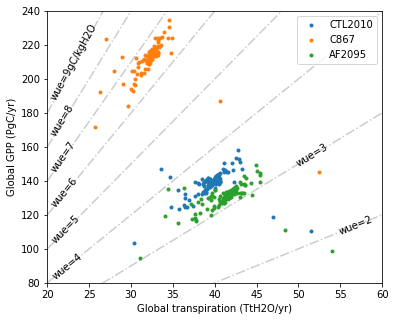

In [75]:
forcings = ['CTL2010','C867','AF2095']
v1 = 'GPP'
v0 = 'FCTR'
d = 'global'
xms = []


plt.figure(figsize=[6,5])
for i in range(nx):

    gpp=gpps[i]
    fctr=fctrs[i]
    f=forcings[i] 
    plt.plot(fctr,gpp,'.',label=f)
    if i==0:
        extras()
    plt.legend()
    fname='../figs/wue_'+str(i+1)+'.pdf'
    plt.savefig(fname)


    

In [81]:
ix=(fctrs[0]>45)&(fctrs[0]<50)
pvals = ds0.param[ix].values
if len(pvals)==1:
    p=str(pvals[0])
    m=str(ds0.minmax[ix].values[0])
    print(p,m)
else:
    print(len(pvals))

medlynslope max


<xarray.DataArray ()>
array(3.50499607)

In [85]:
(gpps[1]/fctrs[1]).mean()/(gpps[0]/fctrs[0]).mean()

<xarray.DataArray ()>
array(1.87908825)

In [86]:
(gpps[2]/fctrs[2]).mean()/(gpps[0]/fctrs[0]).mean()

<xarray.DataArray ()>
array(0.90271107)

In [82]:
ix = np.argsort(gpps[0]/fctrs[0])
ds0.param[ix]

<xarray.DataArray 'param' (ens: 373)>
array(['medlynintercept', 'medlynslope', 'maximum_leaf_wetted_fraction',
       'tpu25ratio', 'leafcn', 'vcmaxha', 'kmax', 'd_max', 'kcha',
       'jmaxha', 'tpuha', 'fnps', 'theta_cj', 'vcmaxse_sf', 'vcmaxhd',
       'KCN', 'lmr_intercept_atkin', 'cv', 'taulnir', 'kn_nonmyc',
       'jmaxb1', 'jmaxb0', 'leaf_long', 'lmrha', 'lmrhd',
       'interception_fraction', 'liq_canopy_storage_scalar', 'kc25_coef',
       'cpha', 'lmrse', 'froot_leaf', 'nstem', 'krmax', 'rholnir',
       'grperc', 'frac_sat_soil_dsl_init', 'rholvis', 'FUN_fracfixers',
       'theta_psii', 'ck', 'k_nitr_max_perday', 'frootcn', 'tpuhd',
       'tpuse_sf', 'z0mr', 'wc2wjb0', 'koha', 'taulvis', 'slatop',
       'jmax25top_sf', 'psi50', 'stem_leaf', 'jmaxse_sf', 'displar',
       'fff', 'jmaxhd', 'tau_s1', 'decomp_depth_efolding',
       'enzyme_turnover_daily', 'rhosnir', 'ko25_coef', 'rstem',
       'br_root', 'cp25_yr2000', 'csoilc', 'q10_mr', 'minpsi_hr', 'zlnd',
       'rf_l2s1_bgc', 'clay_pf', 'freelivfix_slope_wet',
       'upplim_destruct_metamorph', 'kc_nonmyc', 'rf_l1s1_bgc',
       'fun_cn_flex_b', 'sand_pf', 'tau_s2', 'baseflow_scalar', 'r_mort',
       'rhosvis', 'kp25ratio', 'wind_min', 'rootprof_beta', 'tausnir',
       'denitrif_respiration_coefficient', 'xl', 'prh30',
       'snow_canopy_storage_scalar', 'rf_l3s2_bgc', 'tau_s3', 'ndays_on',
...
       'ekn_active', 'rhosvis', 'som_diffus', 'zbedrock_sf', 'tau_l1',
       'fun_cn_flex_b', 'a_coef', 'accum_factor', 'fd_pft', 'fsr_pft',
       'q10_mr', 'denitrif_nitrateconc_exponent', 'n_baseflow',
       'denitrif_respiration_coefficient', 'br_root', 'e_ice', 'tau_s1',
       'ko25_coef', 'medlynintercept', 'jmax25top_sf', 'kmax', 'zlnd',
       'kc25_coef', 'xl', 'minpsi_hr', 'dleaf', 'zsno', 'grperc',
       'rhosnir', 'baseflow_scalar', 'displar', 'maxpsi_hr',
       'rootprof_beta', 'stem_leaf', 'koha', 'clay_pf',
       'freelivfix_slope_wet', 'taulvis', 'frootcn', 'ck', 'rstem',
       'slatop', 'k_nitr_max_perday', 'jmaxha', 'csoilc', 'fnps', 'z0mr',
       'lmrha', 'rholvis', 'leaf_long', 'd_max', 'cp25_yr2000', 'sand_pf',
       'froot_leaf', 'tpuha', 'KCN', 'jmaxb1', 'kn_nonmyc', 'theta_ip',
       'wc2wjb0', 'cpha', 'krmax', 'theta_psii', 'tpu25ratio', 'tpuhd',
       'rholnir', 'FUN_fracfixers', 'taulnir', 'lmr_intercept_atkin',
       'theta_cj', 'fff', 'cv', 'jmaxhd', 'vcmaxha', 'vcmaxse_sf',
       'jmaxse_sf', 'lmrse', 'lmrhd', 'jmaxb0', 'kcha',
       'frac_sat_soil_dsl_init', 'vcmaxhd', 'tpuse_sf', 'nstem', 'leafcn',
       'dleaf', 'liq_canopy_storage_scalar',
       'maximum_leaf_wetted_fraction', 'medlynslope', 'csol_sand',
       'csol_sand'], dtype='<U32')
Coordinates:
  * ens      (ens) int64 355 107 64 122 198 359 141 ... 197 21 71 65 354 59 58

### set up some necessary functions

In [10]:
#define the directory structure to find files
def get_files(name,htape,keys):
    topdir     = '/glade/scratch/djk2120/PPEn11/hist/' 
    thisdir    = topdir+name+'/'
    files      = [glob.glob(thisdir+'*'+key+'*'+htape+'*.nc')[0] for key in keys]
    return files

In [6]:
def calc_mean(ens_name,datavar,la,cfs,units,domain='global'):

    preload = ('/glade/u/home/djk2120/clm5ppe/pyth/data/'+
               ens_name+'_'+datavar+'_'+domain+'.nc')
    if not glob.glob(preload):
        preload = './data/'+ens_name+'_'+datavar+'_'+domain+'.nc'
        if not os.path.isdir('./data/'):
            os.system('mkdir data')
    
    #skip calculation if available on disk
    if not glob.glob(preload):
        data_vars = [datavar]
        files = get_files(ens_name,'h0',keys)
        ds=get_ensemble(files, data_vars, keys, paramkey)
        cf = cfs[datavar]  #conversion factor
        if cf=='intrinsic':
            if domain=='global':
                cf = 1/la.sum()/365
            else:
                cf = 1/la.groupby(ds.biome).sum()/365

        # weight by landarea
        x = la*ds[datavar]
        
        # sort out domain groupings
        x['biome']=ds.biome
        x=x.swap_dims({'gridcell':'biome'})
        if domain =='global': 
            g = 1+0*x.biome  #every gridcell is in biome 1
        else: 
            g = x.biome
        
        # calculate annual average or sum (determined by cf)
        xann = cf*(month_wts(10)*x.groupby(g).sum()).groupby('time.year').sum().compute()

        if domain =='global': 
            xann = xann.mean(dim='biome')  #get rid of gridcell dimension   

        #average/iav
        xm  = xann.mean(dim='year') 
        iav = xann.std(dim='year')

        #save the reduced data
        out = xr.Dataset()
        out[datavar+'_mean'] = xm
        out[datavar+'_mean'].attrs= {'units':units[datavar],
                                     'long_name':ds[datavar].attrs['long_name']}
        out[datavar+'_iav']  = iav
        out[datavar+'_iav'].attrs= {'units':units[datavar],
                                    'long_name':ds[datavar].attrs['long_name']}
        out['param']  = ds.param
        out['minmax'] = ds.minmax
        
        
        if domain=='biome':
            out['biome_name']=ds.biome_name
        
        
        out.load().to_netcdf(preload)
        
    #load from disk
    ds  = xr.open_dataset(preload)
    xm  = ds[datavar+'_mean']
    v = datavar+'_iav'
    if v in ds.data_vars:
        iav = ds[v]
    else:
        iav = []
    
    return xm,iav

### specify some ensemble info

In [11]:
#fetch the paraminfo
csv = '/glade/scratch/djk2120/PPEn11/surv.csv' 
paramkey = pd.read_csv(csv)
keys = paramkey.key

#fetch the sparsegrid landarea
la_file = '/glade/scratch/djk2120/PPEn08/sparsegrid_landarea.nc'
la = xr.open_dataset(la_file).landarea  #km2

#load conversion factors
cfs,units = get_cfs()
files = get_files('CTL2010','h0',keys)

#dummy dataset
p,m = get_params(keys,paramkey)
ds0 = xr.Dataset()
ds0['param']  =xr.DataArray(p,dims='ens')
ds0['minmax'] =xr.DataArray(m,dims='ens')
ds0['key']    =xr.DataArray(keys,dims='ens')

In [9]:
tmp = xr.open_dataset('./data/CTL2010_ALTMAX_biome.nc')
ds0['biome'] = tmp['biome']
ds0['biome_name'] = tmp['biome_name']

NameError: name 'get_files' is not defined

### START HERE

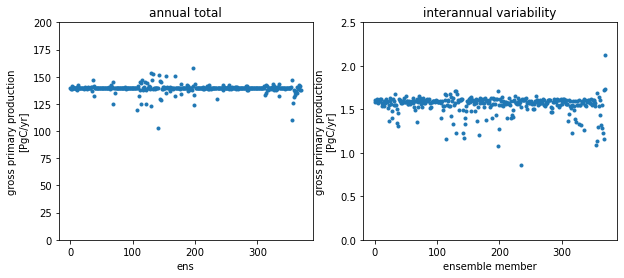

In [16]:
f = 'CTL2010'
v = 'GPP'
xm,iav = calc_mean(f,v,la,cfs,units,domain='global')

plt.figure(figsize=[10,4])
plt.subplot(121)
xm.plot.line('.')
plt.title('annual total')
plt.ylim([0,200])
plt.subplot(122)
iav.plot.line('.')
plt.title('interannual variability')
plt.ylim([0,2.5])
plt.xlabel('ensemble member');

In [17]:
help(rank_plot)

Help on function rank_plot in module ppe_analysis.analysis:

rank_plot(da, ds, nx, ll=True, title=None, xlabel=None)



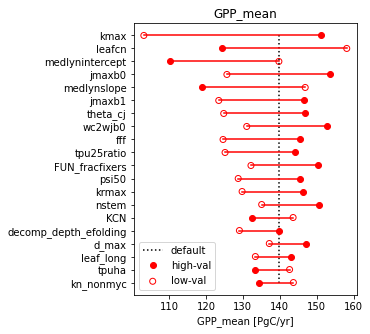

In [20]:
plt.figure(figsize=[4,5])
xm,iav = calc_mean(f,v,la,cfs,units,domain='global')
rank_plot(xm,ds0,20)

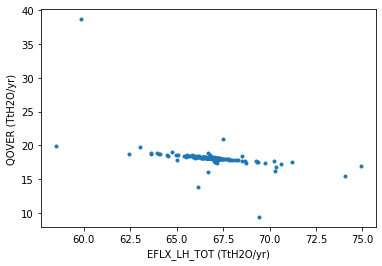

In [141]:
f = 'CTL2010'
v1 = 'EFLX_LH_TOT'
v2 = 'QOVER'
x1,iav = calc_mean(f,v1,la,cfs,units,domain='global')
x2,iav = calc_mean(f,v2,la,cfs,units,domain='global')
plt.plot(x1,x2,'.')
plt.xlabel(v1+' ('+units[v1]+')');
plt.ylabel(v2+' ('+units[v2]+')');

In [153]:
#what is responsible for that anomalous QOVER?
ix = x2>35
p=ds0.param.isel(ens=ix).values
m=ds0.minmax.isel(ens=ix).values
print(p,m)

['fff'] ['min']


In [164]:
#is there a spatial signature to that effect?
ix = x2>35
ix[0]=1  #adding the default case
thiskeys = ds0.key.isel(ens=ix).values
files = get_files('CTL2010','h0',thiskeys)
ds = get_ensemble(files,['QOVER'],thiskeys,paramkey)

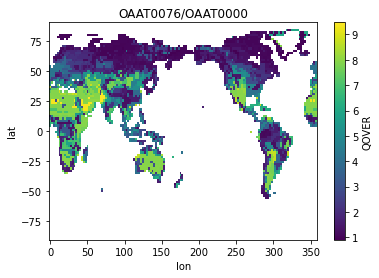

In [175]:
qm = ds.QOVER.mean(dim='time')
dq = qm[1,:]/qm[0,:]
dqmap = get_map(dq)
dqmap.plot()
plt.title(thiskeys[1]+'/'+thiskeys[0]);

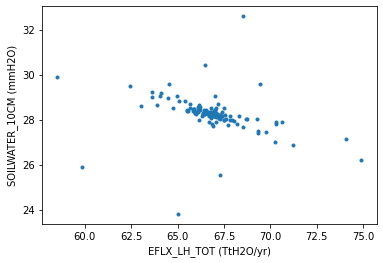

In [176]:
f = 'CTL2010'
v1 = 'EFLX_LH_TOT'
v2 = 'SOILWATER_10CM'
x1,iav = calc_mean(f,v1,la,cfs,units,domain='global')
x2,iav = calc_mean(f,v2,la,cfs,units,domain='global')
plt.plot(x1,x2,'.')
plt.xlabel(v1+' ('+units[v1]+')');
plt.ylabel(v2+' ('+units[v2]+')');

In [178]:
#what is responsible for that high SW10cm?
ix = x2>32
ee = ds0.ens[ix]
p=ds0.param.isel(ens=ix).values
m=ds0.minmax.isel(ens=ix).values
print(p,m)

['sand_pf'] ['min']


In [179]:
#is there a spatial signature to that effect?
ix = x2>32
ix[0]=1  #adding the default case
thiskeys = ds0.key.isel(ens=ix).values
files = get_files('CTL2010','h0',thiskeys)
ds = get_ensemble(files,['SOILWATER_10CM'],thiskeys,paramkey)
qm = ds.SOILWATER_10CM.mean(dim='time')
dq = qm[1,:]/qm[0,:]
dqmap = get_map(dq)

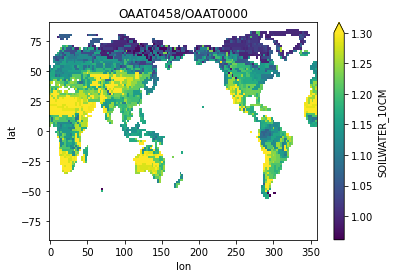

In [181]:
dqmap.plot(vmax=1.3)
plt.title(thiskeys[1]+'/'+thiskeys[0]);

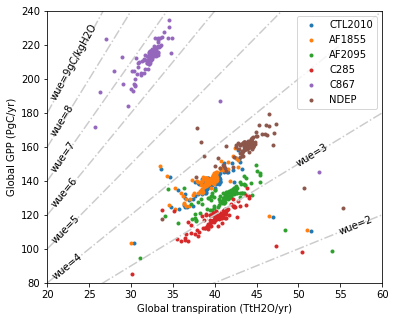

In [21]:
forcings = ['CTL2010','AF1855','AF2095','C285','C867','NDEP']
v1 = 'GPP'
v0 = 'FCTR'
d = 'global'
xms = []

plt.figure(figsize=[6,5])
for f in forcings:
    xm,iav = calc_mean(f,v0,la,cfs,units,domain='global')
    ym,iav = calc_mean(f,v1,la,cfs,units,domain='global')
    plt.plot(xm,ym,'.',label=f)
    
    
xlims = np.array([20,60])
plt.xlim(xlims)
plt.ylim(4*xlims)
plt.legend(loc=1)
plt.xlabel('Global transpiration (TtH2O/yr)')
plt.ylabel('Global GPP (PgC/yr)');


#make the contour lines / labels
xv = np.linspace(20,70,10)
wues = 2+np.arange(8)
for wue in wues:
    plt.plot(xv,wue*xv,'-.',color=[0.8,0.8,0.8])
xlocs = [55,50,21,21,21,21,21,21]
u=''
for x,wue in zip(xlocs,wues):
    t = np.degrees(np.arctan(wue))
    if wue==9:
        u='gC/kgH2O'
    plt.text(x,wue*x-2,'wue='+str(wue)+u,rotation=t,
             rotation_mode='anchor',transform_rotates_text=True)
    

In [3]:
#pft-data

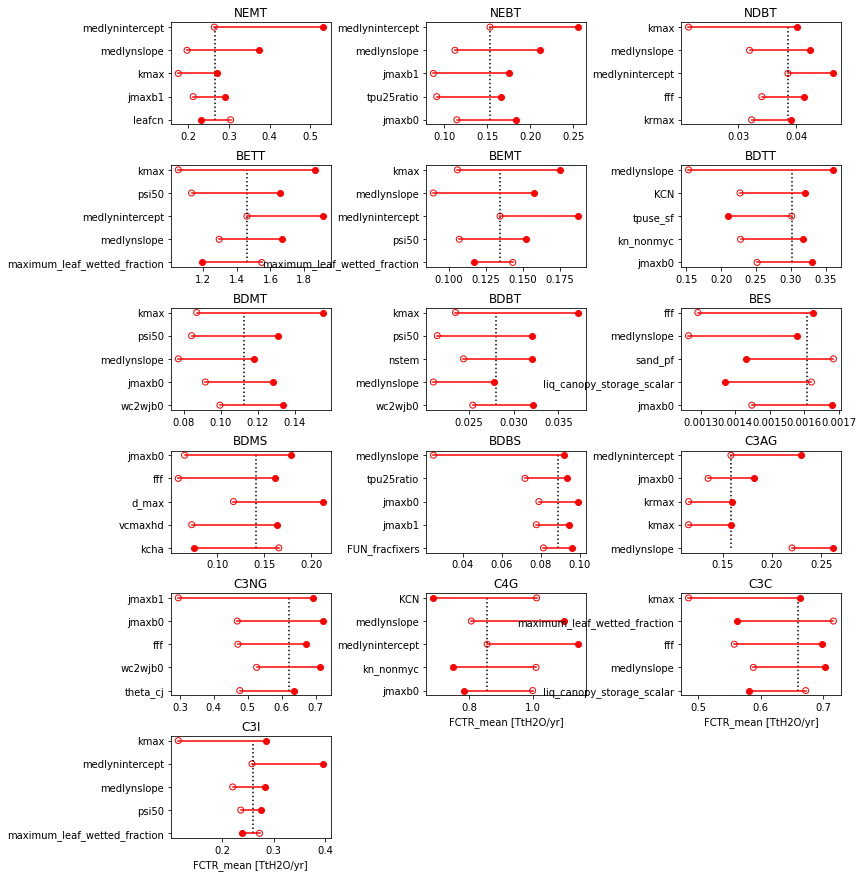

In [21]:
ens='CTL2010'
datavar='FCTR'
preload = './data/'+ens+'_'+datavar+'_pft.nc'
ds = xr.open_dataset(preload)
dv = datavar+'_mean'
plt.figure(figsize=[12,15])
for pft in 1+np.arange(16):
    plt.subplot(6,3,pft)
    rank_plot(ds[dv].sel(pft=pft),ds0,5,ll=False)
    plt.title(ds.pftkey.sel(pft=pft).values);
    if pft<14:
        plt.xlabel('')
plt.subplots_adjust(hspace=0.4)
plt.subplots_adjust(wspace=0.6)

In [22]:
ens='CTL2010'
datavar='GPP'
preload = './data/'+ens+'_'+datavar+'_pft.nc'
ds = xr.open_dataset(preload)
dv = datavar+'_mean'
plt.figure(figsize=[12,15])
for pft in 1+np.arange(16):
    plt.subplot(6,3,pft)
    rank_plot(ds[dv].sel(pft=pft),ds0,5,ll=False)
    plt.title(ds.pftkey.sel(pft=pft).values);
    if pft<14:
        plt.xlabel('')
plt.subplots_adjust(hspace=0.4)
plt.subplots_adjust(wspace=0.6)

FileNotFoundError: [Errno 2] No such file or directory: b'/glade/u/home/djk2120/clm5ppe/pyth/data/CTL2010_GPP_pft.nc'

KeyError: 'units'

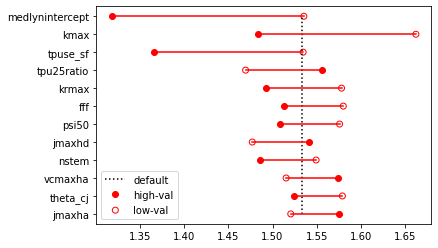

In [27]:
ens='CTL2010'
datavar='GPP'
preload = './data/'+ens+'_'+datavar+'_global.nc'
ds = xr.open_dataset(preload)
dv = datavar+'_mean'
x1 = ds[dv]
ens='C867'
datavar='GPP'
preload = './data/'+ens+'_'+datavar+'_global.nc'
ds = xr.open_dataset(preload)
dv = datavar+'_mean'
x2 = ds[dv]

rank_plot(x2/x1,ds0,12)


### non-annual example
 - does summer GPP, come at the expense of fall?

In [76]:
help(get_ensemble)

Help on function get_ensemble in module ppe_analysis.analysis:

get_ensemble(files, data_vars, keys, paramkey, p=True, extras=[])



In [77]:
files = get_files('CTL2010','h0',keys)
ds = get_ensemble(files,['GPP'],keys,paramkey)

In [78]:
cf = cfs['GPP']
gpp_seas = cf/10*(month_wts(10)*(la*ds.GPP).sum(dim='gridcell')).groupby('time.season').sum().compute()

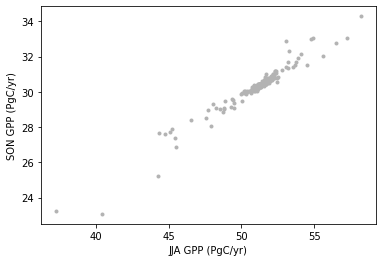

In [79]:
plt.plot(gpp_seas.sel(season='JJA'),gpp_seas.sel(season='SON'),'.',color=[0.7,0.7,0.7]);
plt.xlabel('JJA GPP (PgC/yr)')
plt.ylabel('SON GPP (PgC/yr)');

In [80]:
#across the ensemble, no

In [111]:
s=ds['time.season'].values
s2 = np.zeros(len(s))
seasons = ['DJF','MAM','JJA','SON']
for i,seas in enumerate(seasons):
    ix = s==seas
    s2[ix]=i

g = ds['time.year'].values*100+s2
g = xr.DataArray(g,dims='time')

In [125]:
cf=cfs['GPP']
gpps = cf*(la*(month_wts(10)*ds.GPP).groupby(g).sum()).sum(dim='gridcell').compute()

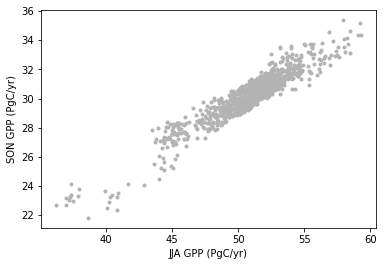

In [132]:
ix1 = 4*np.arange(10)+2
ix2 = 4*np.arange(10)+3
for ee in range(371):
    plt.plot(gpps.isel(ens=ee)[ix1],gpps.isel(ens=ee)[ix2],'.',color=[0.7,0.7,0.7])
plt.xlabel('JJA GPP (PgC/yr)')
plt.ylabel('SON GPP (PgC/yr)');

In [130]:
#likewise if you look across years